In [24]:
import time
from itertools import product

import matplotlib.pyplot as plt
import mlrose_hiive
import pandas as pd
import seaborn as sns
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix, f1_score)
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from transform_data import get_train_test_ds

random_state = 42
cv = 3
mlp_layers = [64, 16]

In [2]:
X, X_train, X_test, y, y_train, y_test = get_train_test_ds('income', 'data/adult.data', random_state)
X_train

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,male,education_10th,education_11th,education_12th,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male
0,32,37210,13,0,0,45,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,43,101950,14,0,0,45,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,20,122244,9,0,0,28,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,40,24763,10,6849,0,40,1,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,24,113936,13,0,0,40,1,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26043,35,179171,9,0,0,38,0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
26044,39,421633,10,0,0,30,0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
26045,55,82098,9,0,0,55,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
26046,26,50053,13,0,0,55,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [3]:
clf = mlrose_hiive.NeuralNetwork(
  hidden_nodes=mlp_layers, 
  activation ='relu', 
  algorithm ='genetic_alg', 
  max_iters=1000, 
  bias=True, 
  is_classifier=True, 
  early_stopping=True, 
  max_attempts=100, 
  random_state=random_state, 
  curve=True
)
pipe = Pipeline([
  ('scaler', StandardScaler()), 
  ('ga', clf),
])

In [4]:
# CV search
param_grid = {
    'ga__learning_rate': [0.0001, 0.01, 0.1, 1],
    'ga__pop_size': [200, 400, 800],
}

best_score = None
best_params = None
df_cols = list(param_grid.keys()) + ['score']
metrics_dict = {
    k: [] for k in df_cols
}

param_combinations = product(*param_grid.values())
for params in param_combinations:
    try_param = dict(zip(param_grid.keys(), params))
    print(try_param)
    pipe.set_params(**try_param)
    
    # Perform cross-validation
    kf = KFold(n_splits=cv)
    k = 0
    scores = []
    for train_index, valid_index in kf.split(X_train):
        start = time.time()
        k += 1
        X_split_train, X_valid = X_train.loc[train_index], X_train.loc[valid_index]
        y_split_train, y_valid = y_train.loc[train_index], y_train.loc[valid_index]
        pipe.fit(X_split_train, y_split_train)
        y_pred = pipe.predict(X_valid)
        score = f1_score(y_valid, y_pred)
        scores.append(score)
        end = time.time()
        run_time = end - start
        print(f"k{k} run time: {run_time}s")
    
    # Calculate mean score across all folds
    mean_score = sum(scores) / len(scores)
    for k, v in try_param.items():
        metrics_dict[k].append(v)
    metrics_dict['score'].append(mean_score)
metrics_df = pd.DataFrame(metrics_dict)
metrics_df

{'ga__learning_rate': 0.0001, 'ga__pop_size': 200}
k1 run time: 2606.769498348236s
k2 run time: 3697.211665391922s
k3 run time: 2651.0115661621094s
{'ga__learning_rate': 0.0001, 'ga__pop_size': 400}
k1 run time: 3019.8612015247345s
k2 run time: 3415.216928243637s
k3 run time: 2478.217500448227s
{'ga__learning_rate': 0.0001, 'ga__pop_size': 800}
k1 run time: 11341.811937570572s
k2 run time: 4530.991145133972s
k3 run time: 9592.170137405396s
{'ga__learning_rate': 0.01, 'ga__pop_size': 200}
k1 run time: 2253.2414083480835s
k2 run time: 3186.0988545417786s
k3 run time: 2281.0372812747955s
{'ga__learning_rate': 0.01, 'ga__pop_size': 400}
k1 run time: 3004.579126358032s
k2 run time: 3440.2402534484863s
k3 run time: 2492.233832836151s
{'ga__learning_rate': 0.01, 'ga__pop_size': 800}
k1 run time: 11436.031895637512s
k2 run time: 4572.6737287044525s
k3 run time: 10543.362524747849s
{'ga__learning_rate': 0.1, 'ga__pop_size': 200}
k1 run time: 2456.9924352169037s
k2 run time: 3407.32976603508s
k3

,ga__learning_rate,ga__pop_size,score
0,0.0001,200,0.531097
1,0.0001,400,0.502535
2,0.0001,800,0.532196
3,0.0100,200,0.531097
4,0.0100,400,0.502535
5,0.0100,800,0.532196
6,0.1000,200,0.531097
7,0.1000,400,0.502535
8,0.1000,800,0.532196
9,1.0000,200,0.531097


In [5]:
metrics_df.to_parquet("./metrics/ga_metrics.parquet")

In [ ]:
metrics_df = pd.read_parquet("./metrics/ga_metrics.parquet")

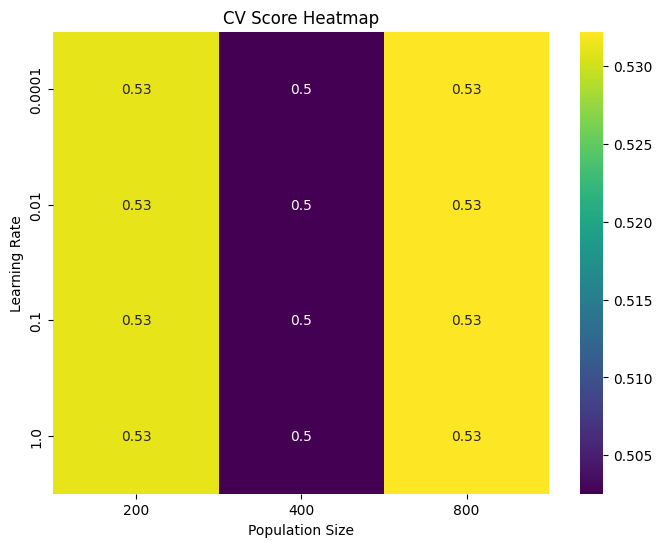

In [28]:
heatmap_data = metrics_df.pivot(index='ga__learning_rate', columns='ga__pop_size', values='score')
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap='viridis')

# Set labels and title
plt.xlabel('Population Size')
plt.ylabel('Learning Rate')
plt.title('CV Score Heatmap')

plt.show()

In [19]:
params_key = [x for x in metrics_df.columns.to_list() if x != 'score']
best_params = metrics_df.sort_values(['score'], ascending=False)[params_key].iloc[0].to_dict()
for k in params_key:
    if best_params[k] % 1 != 0:
        continue
    best_params[k] = int(best_params.pop(k))
best_params

{'ga__learning_rate': 0.0001, 'ga__pop_size': 800}

In [20]:
# train model on full dataset
pipe.set_params(**best_params)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

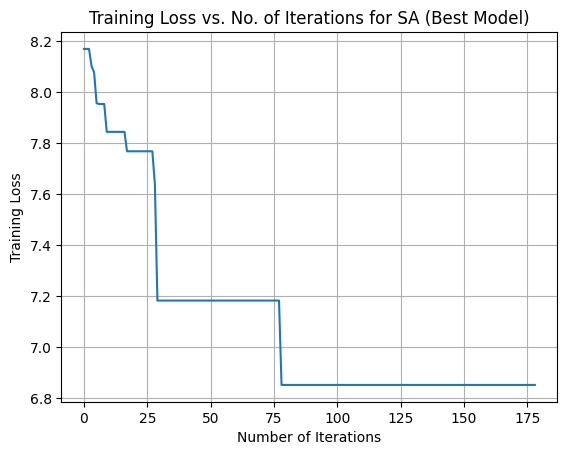

In [21]:
plt.figure()
plt.plot(pipe['ga'].fitness_curve[:, 0])
plt.grid()
plt.xlabel('Number of Iterations')
plt.ylabel('Training Loss')
plt.title('Training Loss vs. No. of Iterations for SA (Best Model)')
plt.show()

In [22]:
classification_report(y_test, y_pred, output_dict=True)

{'0': {'precision': 0.8513307984790874,
  'recall': 0.9055611729019212,
  'f1-score': 0.877609015188633,
  'support': 4945.0},
 '1': {'precision': 0.627294493216281,
  'recall': 0.5012755102040817,
  'f1-score': 0.5572492024104927,
  'support': 1568.0},
 'accuracy': 0.8082296944572394,
 'macro avg': {'precision': 0.7393126458476842,
  'recall': 0.7034183415530014,
  'f1-score': 0.7174291087995628,
  'support': 6513.0},
 'weighted avg': {'precision': 0.797394221379121,
  'recall': 0.8082296944572394,
  'f1-score': 0.8004826239041061,
  'support': 6513.0}}

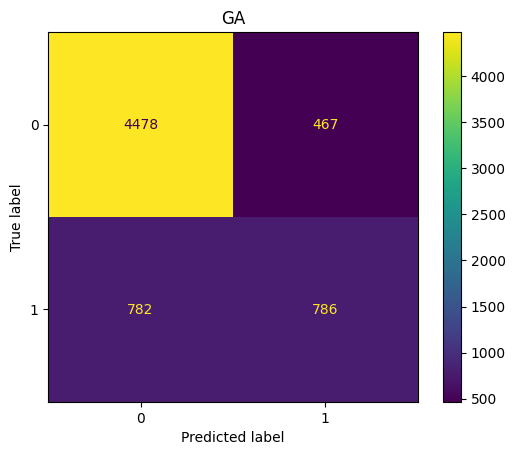

In [25]:
classes = [0, 1]
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("GA")
plt.show()